In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import sys
sys.path.append(r"C:\Users\Bruker\OneDrive\Dokumenter\NTNU\4D_CT\Plotting")
sys.path.append(r"C:\Users\Bruker\OneDrive\Dokumenter\NTNU\4D_CT\CT")
sys.path.append(r"C:\Users\Bruker\OneDrive\Dokumenter\NTNU\4D_CT\3DTomoGAN")
from plots import *
import os
import utils
import h5py
from scipy.optimize import curve_fit
from PIL import Image

import scipy.ndimage as nd

from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.patheffects as PathEffects

%matplotlib inline

%reload_ext autoreload
%autoreload 2

In [12]:
root = r"C:\Users\Bruker\Documents\4DCT"
choose_formatter(False)

In [13]:
# Load .npy files

x1, x2 = 672, 928
y1, y2 = 384, 640
z1, z2 = 384, 640

slice = [[x1, x2], [y1, y2], [z1, z2]]

names = [
    "hourglassV3_13_55",
]

crossections = {
    # "favg6":  {"name": names[0] },
    # "favg12": { "name": names[1]},
    # "favg24": {"name": names[2]},
}

identifiers = [
    "gt",
    "Rec_0_1_fdk",
    "Rec_0_2_fdk",
    "Rec_0_3_fdk",
    "Rec_0_4_fdk",
    "Rec_0_5_fdk",
    "Rec_0_6_fdk",
    "Rec_0_7_fdk",
    "Rec_0_8_fdk",
    "Rec_0_1_fdk_enhanced_800512512",
    "Rec_0_2_fdk_enhanced_800512512",
    "Rec_0_3_fdk_enhanced_800512512",
    "Rec_0_4_fdk_enhanced_800512512",
    "Rec_0_5_fdk_enhanced_800512512",
    "Rec_0_6_fdk_enhanced_800512512",
    "Rec_0_7_fdk_enhanced_800512512",
    "Rec_0_8_fdk_enhanced_800512512",

]
keys = [
    "gt",
    "13",
    "26",
    "39",
    "52",
    "65",
    "78",
    "91",
    "104",
    "13_enhanced",
    "26_enhanced",
    "39_enhanced",
    "52_enhanced",
    "65_enhanced",
    "78_enhanced",
    "91_enhanced",
    "104_enhanced",
]

# for k, v in crossections.items():
for j,(id,key) in enumerate(zip(identifiers, keys)):

    if key.endswith("enhanced"):
        x1, x2 = 0,256
        y1, y2 = 0,256
        z1, z2 = 0,256
    else:
        x1, x2 = 672, 928
        y1, y2 = 384, 640
        z1, z2 = 384, 640

    load_name = f"{names[0]}_{identifiers[j]}_{x1}_{x2}_{y1}_{y2}_{z1}_{z2}.npy"
    load_path = os.path.join(root, load_name)
    crossections[key]= np.squeeze(np.load(load_path))

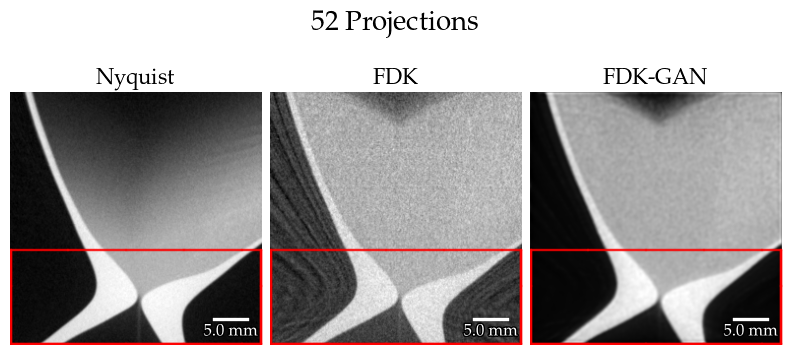

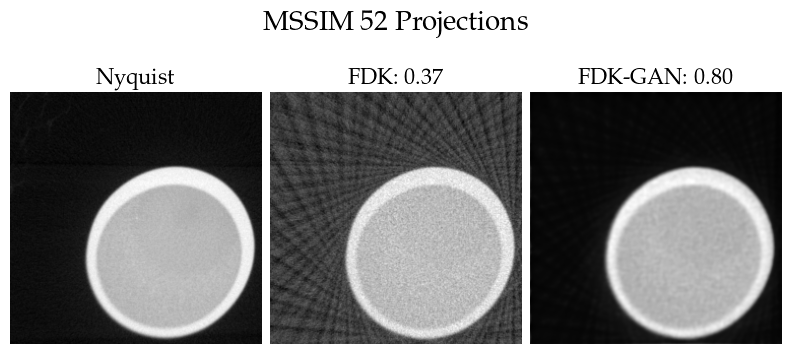

In [23]:
ps = 52

slice_norm = lambda x, ref : x* (np.max(ref) - np.min(ref)) + np.min(ref)
slgt = ( crossections["gt"][:,:,180] )#- np.min(crossections["gt"]) ) / ( np.max(crossections["gt"]) - np.min(crossections["gt"]) )
slin = ( crossections[f"{ps}"][:,:,180] )#- np.min(crossections["39"]) ) / ( np.max(crossections["39"]) - np.min(crossections["39"]) )
slout = slice_norm(crossections[f"{ps}_enhanced"][:,:,180], crossections["gt"]) # - np.min(crossections["39_enhanced"]) / ( np.max(crossections["39_enhanced"]) - np.min(crossections["39_enhanced"]) )

# ssin, _ = evaluate(slgt, slin, normalise=False)
# ssout,_ = evaluate(slgt, slout, normalise=False)

varin = None
varout = None #RSD: New metric.

mask = [[160, i] for i in range(256)]
mask.extend([[255, i] for i in range(256)])
mask.extend([[255, i] for i in range(256)])
mask.extend([[i, 1] for i in range(160,256)])
mask.extend([[i, 1] for i in range(160,256)])
mask.extend([[i, 255] for i in range(160,256)])
mask.extend([[i, 255] for i in range(160,256)])
mask = np.array(mask).T

plot_slice_grid(
    [slgt, slin, slout],
    ["Nyquist", f"FDK", f"FDK-GAN"],
    bar=True,
    scalebar_kwargs = scale_kwargs,
    folder ="Hourglass4D",
    suptitle=f"{ps} Projections",
    savefig=False,
    savefile=f"Hourglass4D_{ps}_projections",
    mask=mask,
    fs = (1,2))

#RSD: Red line is crossection. Inside rec box is MSSIM and PSNR score for total. 

h = 160 

slgt = (crossections["gt"][h]) # - np.min(crossections["gt"])) / ( np.max(crossections["gt"]) - np.min(crossections["gt"]) )
slin = (crossections[f"{ps}"][h]) # - np.min(crossections["39"])) / ( np.max(crossections["39"]) - np.min(crossections["39"]) )
slout = slice_norm( crossections[f"{ps}_enhanced"][h], crossections["gt"]) #- np.min(crossections["39_enhanced"])) / ( np.max(crossections["39_enhanced"]) - np.min(crossections["39_enhanced"]) )

ssin, _ = utils.calc_mssim(slgt, slin) #evaluate(slgt, slin, normalise=False)
ssout,_ = utils.calc_mssim(slgt, slout) #evaluate(slgt, slout, normalise=False)


plot_slice_grid(
    [slgt, slin, slout],
    ["Nyquist", f"FDK: {ssin:.2f}", f"FDK-GAN: {ssout:.2f}"],
    bar=False,
    folder ="Hourglass4D",
    suptitle=f"MSSIM {ps} Projections",
    savefig=False,
    savefile=f"Hourglass4D_crossection_{ps}_projections",
    fs = (1,2))


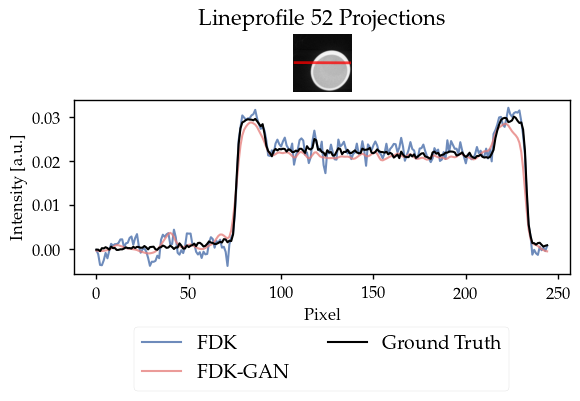

In [31]:
# Line profile

input_norm = (crossections[f"{ps}"][h])#- np.min(crossections['39'])) / (np.max(crossections["39"]) - np.min(crossections['39']))
gt_norm = (crossections["gt"][h])#- np.min(crossections['gt'])) / (np.max(crossections["gt"]) - np.min(crossections['gt']))
output_norm = slice_norm(crossections["39_enhanced"][h], crossections["gt"])#- np.min(crossections['39_enhanced'])) / (np.max(crossections["39_enhanced"]) - np.min(crossections['39_enhanced']))

imgs = [input_norm, output_norm]
labels = ["FDK", "FDK-GAN"]
plot_line_profile(imgs, labels, gt_norm, idxs= [128, 129, 10,255], folder="Hourglass4D", title=f"Lineprofile {ps} Projections", savefig=True, savefile=f"Hourglass4D_line_profile_{ps}_projections")


# fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True)
# ax1.xcorr(gt_norm[128].flatten(), input_norm[128].flatten(), usevlines=True, maxlags=None, normed=False)
# ax2.xcorr(gt_norm[128].flatten(), output_norm[128].flatten(), usevlines=True, maxlags=None, normed=False)
# plt.show()

FDK: 23.83
-0.009770108 0.008704074
FDK-GAN: 24.74
-0.012111448 0.0033811477


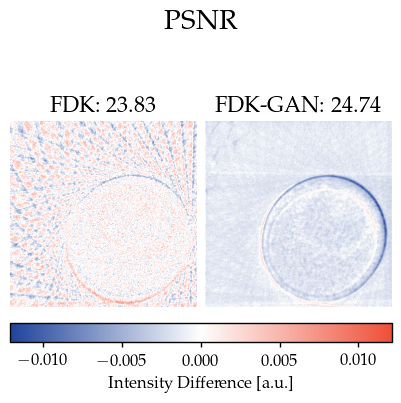

In [32]:
slgt = (crossections["gt"][h] )#- np.min(crossections["gt"]) ) / (np.max(crossections["gt"]) - np.min(crossections["gt"]))
slin = (crossections[f"{ps}"][h] )#- np.min(crossections["39"]) ) / (np.max(crossections["39"]) - np.min(crossections["39"]))
slout = slice_norm(crossections[f"{ps}_enhanced"][h], crossections["gt"]) #- np.min(crossections["39_enhanced"]) ) / (np.max(crossections["39_enhanced"]) - np.min(crossections["39_enhanced"]))

psin = utils.calc_psnr(slgt, slin) # evaluate(slgt, slin, normalise=False)
psout = utils.calc_psnr(slgt, slout) #evaluate(slgt, slout, normalise=False)

import matplotlib as mpl
plot_slice_grid(
    [ -slgt+slin, -slgt+slout],
    [f"FDK: {psin:.2f}", f"FDK-GAN: {psout:.2f}"],
    bar=False,
    folder ="Hourglass4D",
    suptitle="PSNR",
    savefig=True,
    savefile=f"Hourglass4D_crossection_difference_{ps}_projections",
    cm=XRDCT_diverging_cmp,
    two_sided=True,
    fs=(1,1))

# fig = plt.figure()

# gs = fig.add_gridspec(3, 4)
# ax1 = fig.add_subplot(gs[0:2, 0:2])
# ax2 = fig.add_subplot(gs[0:2, 2:4])
# ax3 = fig.add_subplot(gs[2, :])
# cmap = "gray"

# vmin = np.min([np.min(slgt-slin), np.min(slgt-slout)])
# vmax = np.max([np.max(slgt-slin), np.max(slgt-slout)])
# im1=ax1.imshow(slgt-slin, cmap=cmap, vmin=vmin, vmax=vmax)
# ax1.set_title(f"Input PSNR: {psin:.2f}")
# ax1.axis("off")

# im=ax2.imshow(slgt-slout, cmap=cmap, vmin=vmin, vmax=vmax)
# ax2.set_title(f"Output PSNR: {psout:.2f}")
# ax2.axis("off")

# # im1.set_clim(-1,1)


# norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
# cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=ax3, orientation="horizontal")


# # fig.colorbar(im1, cmap=cmap, ax=ax3, orientation="horizontal")# NOT WORKING
# # plt.colorbar(im1)
# plt.show()


In [15]:
identifiers_it = [
    "gt",
    "Rec_0_1_sirt",
    "Rec_0_3_sirt",
]
keys_it = [
    "gt",
    "26",
    "52",]

it_crossections = {}

# for k, v in crossections.items():
for j,(id,key) in enumerate(zip(identifiers_it, keys_it)):

    if key.endswith("enhanced"):
        x1, x2 = 0,256
        y1, y2 = 0,256
        z1, z2 = 0,256
    else:
        x1, x2 = 672, 928
        y1, y2 = 384, 640
        z1, z2 = 384, 640

    load_name = f"{names[0]}_{identifiers_it[j]}_{x1}_{x2}_{y1}_{y2}_{z1}_{z2}{'' if key=='gt' else '_it100' }.npy"
    load_path = os.path.join(root, load_name)
    it_crossections[key]= np.squeeze(np.load(load_path))

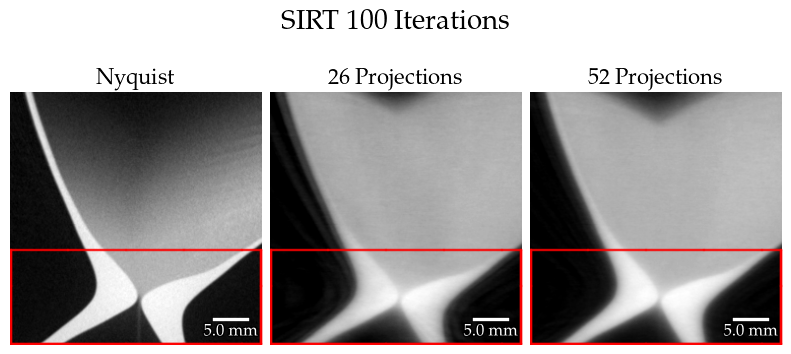

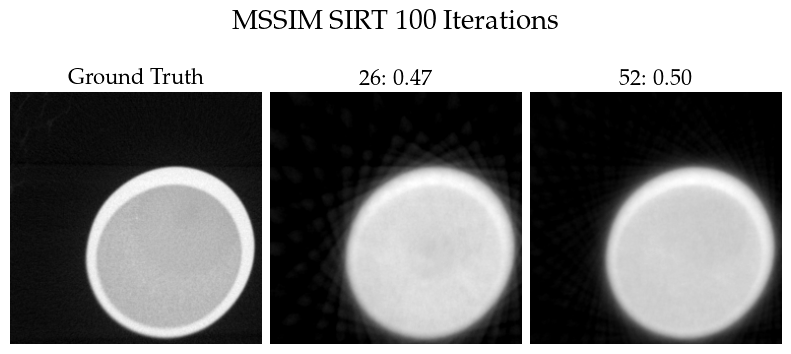

In [19]:
itgt = (it_crossections["gt"][:,:,180])# - np.min(it_crossections["gt"])) / (np.max(it_crossections["gt"]) - np.min(it_crossections["gt"]))
itin = (it_crossections["26"][:,:,180])# - np.min(it_crossections["13"])) / (np.max(it_crossections["13"]) - np.min(it_crossections["13"]))
itout= (it_crossections["52"][:,:,180])# - np.min(it_crossections["39"])) / (np.max(it_crossections["39"]) - np.min(it_crossections["39"]))

itssin, _ = utils.calc_mssim(itgt, itin) #evaluate(itgt, itin, normalise=False)
itssout,_ = utils.calc_mssim(itgt, itout) #evaluate(itgt, itout, normalise=Falseout

scale_kwargs = {
    "size": 5 / (0.2 * 930) * 1350,
    "label": f"5.0 mm",
    "color": "white",
    "loc": 4,
    "frameon": False,
    "size_vertical": 3,
    "label_top": False,
    # "font_properties": {"size": 16}
}

plot_slice_grid(
    [itgt, itin, itout],
    ["Nyquist", f"26 Projections", f"52 Projections"],
    bar=True,
    scalebar_kwargs=scale_kwargs,
    mask=mask,
    folder ="Hourglass4D",
    suptitle="SIRT 100 Iterations",
    savefig=True,
    savefile="Hourglass4D_SIRT",
    fs = (1,2),)

h = 160 

itgt = (it_crossections["gt"][h])# - np.min(it_crossections["gt"])) / (np.max(it_crossections["gt"]) - np.min(it_crossections["gt"]))
itin = (it_crossections["26"][h])# - np.min(it_crossections["13"])) / (np.max(it_crossections["13"]) - np.min(it_crossections["13"]))
itout =( it_crossections["52"][h])# - np.min(it_crossections["39"])) / (np.max(it_crossections["39"]) - np.min(it_crossections["39"]))

itssin, _ = utils.calc_mssim(itgt, itin) #evaluate(itgt, itin, normalise=False)
itssout,_ = utils.calc_mssim(itgt, itout) #evaluate(itgt, itout, normalise=Falseout


plot_slice_grid(
    [itgt, itin, itout],
    ["Ground Truth", f"26: {itssin:.2f}", f"52: {itssout:.2f}"],
    bar=False,
    folder ="Hourglass4D",
    suptitle="MSSIM SIRT 100 Iterations",
    savefig=False,
    savefile="Hourglass4D_crossection_SIRT",
    fs = (1,2))

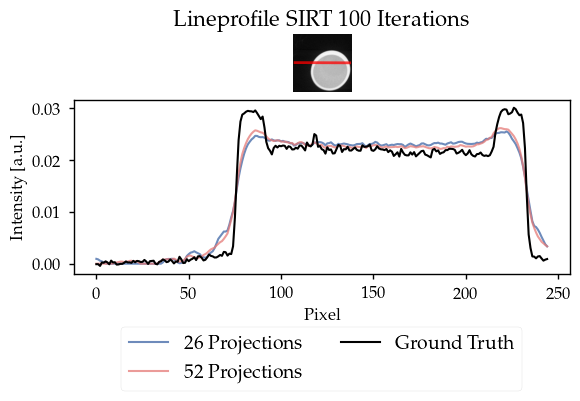

26 PSNR: 22.09
-0.010435903 0.008942051
52 PSNR: 23.03
-0.00957945 0.008362306


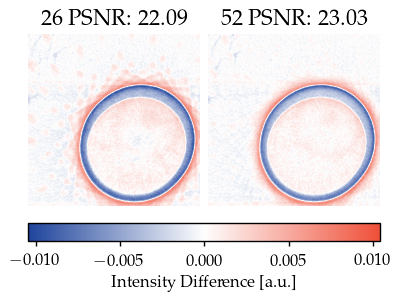

In [152]:
h=160
itgt_norm = (it_crossections["gt"][h] )#- np.min(it_crossections["gt"]) ) / (np.max(it_crossections["gt"]) - np.min(it_crossections["gt"]))
itin_norm = (it_crossections["26"][h] )#- np.min(it_crossections["13"]) ) / (np.max(it_crossections["13"]) - np.min(it_crossections["13"]))
itout_norm = (it_crossections["52"][h])# - np.min(it_crossections["39"]) ) / (np.max(it_crossections["39"]) - np.min(it_crossections["39"]))

_, itpsin = evaluate( itgt_norm, itin_norm, normalise=False)
_,itpsout = evaluate(itgt_norm,itout_norm, normalise=False)

imgs = [itin_norm, itout_norm]
labels = ["26 Projections", "52 Projections"]
plot_line_profile(imgs, labels, itgt_norm, idxs= [128, 129, 10,255], folder="Hourglass4D", title="Lineprofile SIRT 100 Iterations", savefig=True, savefile="Hourglass4D_line_profile_SIRT")


plot_slice_grid(
    [-itgt_norm + itin_norm, -itgt_norm + itout_norm],
    [f"26 PSNR: {itpsin:.2f}", f"52 PSNR: {itpsout:.2f}"],
    bar=False,
    folder ="Hourglass4D",
    suptitle=None,
    savefig=True,
    two_sided=True,
    savefile="Hourglass4D_crossection_difference_SIRT",
    cm=XRDCT_diverging_cmp,
    fs=(1,1))



    
    


(256, 256)


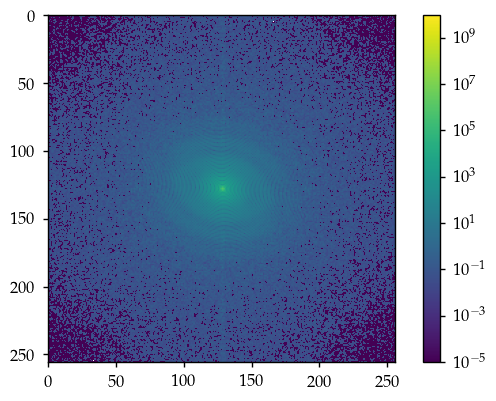

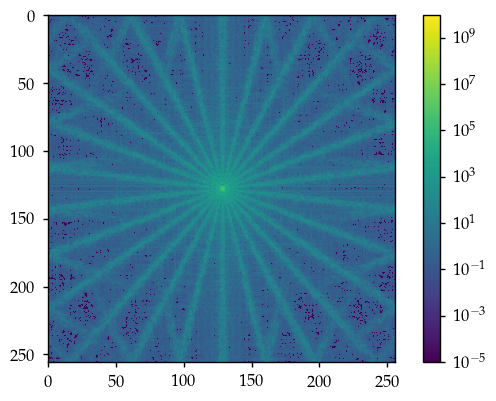

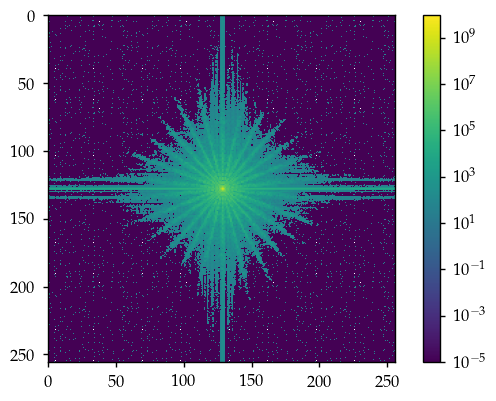

181.01933598375618
128
(26529,)


100%|██████████| 26529/26529 [05:08<00:00, 85.87it/s]


(26529,)


100%|██████████| 26529/26529 [05:07<00:00, 86.35it/s]


(26529,)


100%|██████████| 26529/26529 [05:28<00:00, 80.87it/s]


(26529,)


100%|██████████| 26529/26529 [05:58<00:00, 74.03it/s]


(26529,)


100%|██████████| 26529/26529 [05:25<00:00, 81.61it/s]


(26529,)


100%|██████████| 26529/26529 [05:09<00:00, 85.71it/s]


(26529,)


100%|██████████| 26529/26529 [04:51<00:00, 90.86it/s]


(26529,)


100%|██████████| 26529/26529 [04:40<00:00, 94.53it/s]


(26529,)


100%|██████████| 26529/26529 [04:38<00:00, 95.14it/s]


(26529,)


100%|██████████| 26529/26529 [04:39<00:00, 94.96it/s]


(26529,)


100%|██████████| 26529/26529 [04:38<00:00, 95.19it/s]


(26529,)


100%|██████████| 26529/26529 [04:40<00:00, 94.54it/s]


(26529,)


100%|██████████| 26529/26529 [05:00<00:00, 88.29it/s]


(26529,)


100%|██████████| 26529/26529 [05:31<00:00, 80.02it/s]


(26529,)


100%|██████████| 26529/26529 [05:23<00:00, 81.93it/s] 


(26529,)


100%|██████████| 26529/26529 [05:23<00:00, 81.93it/s]


In [98]:
import scipy as sp
from matplotlib import colors
from tqdm import tqdm
import re

choose_formatter(False)

gt_k = sp.fft.fftshift(sp.fft.fftn(crossections["gt"][h,:,:]))
in_k = sp.fft.fftshift(sp.fft.fftn(crossections["13"][h,:,:]))
out_k = sp.fft.fftshift(sp.fft.fftn(crossections["13_enhanced"][h,:,:]))

print(gt_k.shape)

plt.imshow(np.abs(gt_k**2), norm = colors.LogNorm(vmin=1e-5, vmax=1e10))
plt.colorbar()
plt.show()
plt.imshow(np.abs(in_k**2), norm = colors.LogNorm(vmin=1e-5, vmax=1e10))
plt.colorbar()
plt.show()
plt.imshow(np.abs(out_k**2), norm = colors.LogNorm(vmin=1e-5, vmax=1e10))
plt.colorbar()
plt.show()



X, Y = np.meshgrid(np.arange(256), np.arange(256))

radius = np.sqrt((X - 128)**2 + (Y - 128)**2).flatten()
print(radius.max())


def FSC(gt, elem, sizes= (256,256,256)):
    gt_k = sp.fft.fftshift(sp.fft.fftn(gt)).flatten()
    elem_k = sp.fft.fftshift(sp.fft.fftn(elem)).flatten()

    X, Y, Z = np.meshgrid(np.arange(sizes[0]), np.arange(sizes[1]), np.arange(sizes[2]))

    radius = np.sqrt((X - sizes[0]//2)**2 + (Y - sizes[1]//2)**2 + (Z-sizes[2]//2)**2).flatten()

    uniques = np.unique(radius)
    print(uniques.shape)

    FSCR = np.zeros_like(uniques, dtype=np.complex64)

    for i,u in enumerate(tqdm(uniques)):

        gt_kr = gt_k[np.where(radius == u)]
        elem_kr = elem_k[np.where(radius == u)]

        upper = np.sum(gt_kr * np.conj(elem_kr))

        lower = np.sqrt(np.sum(np.abs(gt_kr)**2) * np.sum(np.abs(elem_kr)**2))

        FSCR[i] = upper / lower

    return FSCR, uniques


fq_keys = ["13", "26", "39", "52", "65", "78", "91", "104"]

tot = 256
evsize = 128

x1, x2 = 160, 256
y1, y2 = 0, 256
z1, z2 = 0, 256

# X, Y, Z = np.meshgrid(np.arange(evsize), np.arange(evsize), np.arange(evsize))
X, Y, Z = np.meshgrid(np.arange(x2-x1), np.arange(y2-y1), np.arange(z2-z1))
evsizes = (x2-x1, y2-y1, z2-z1)

radius = np.sqrt((X - evsizes[0]//2)**2 + (Y - evsizes[1]//2)**2 + (Z-evsizes[2]//2)**2).flatten()

uniques = np.unique(radius)




normalise = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x))

gt_3D = normalise(crossections["gt"][x1 : x2, y1:y2, z1:z2])

ins_3D = {}
for k in fq_keys:
    ins_3D[k] = normalise(crossections[k][x1 : x2, y1:y2, z1:z2])

outs_3D = {}
for k in fq_keys:
    outs_3D[k+"_enhanced"] = normalise(crossections[k+"_enhanced"][x1 : x2, y1:y2, z1:z2])


# fscrs, uniquess 


print(tot//2)
outputs = [FSC(
    gt_3D,#[tot//2-evsize//2: tot//2+evsize//2, tot//2-evsize//2:tot//2+evsize//2, tot//2-evsize//2:tot//2+evsize//2], 
    ins_3D[st],#[tot//2-evsize//2: tot//2+evsize//2, tot//2-evsize//2:tot//2+evsize//2, tot//2-evsize//2:tot//2+evsize//2], 
    sizes=(evsizes[0],evsizes[1],evsizes[2])) for st in fq_keys ]

fq_keys_enhanced = ["13_enhanced", "26_enhanced", "39_enhanced", "52_enhanced", "65_enhanced", "78_enhanced", "91_enhanced", "104_enhanced"]
outputs_enhanced = [FSC(gt_3D,#[tot//2-evsize//2: tot//2+evsize//2, tot//2-evsize//2:tot//2+evsize//2, tot//2-evsize//2: tot//2+evsize//2], 
                        outs_3D[st], #[tot//2-evsize//2: tot//2+evsize//2, tot//2-evsize//2:tot//2+evsize//2, tot//2-evsize//2:tot//2+evsize//2], 
                        sizes=(evsizes[0], evsizes[1], evsizes[2])) for st in fq_keys_enhanced ]



In [99]:
np.save("FDK_FSCs.npy", outputs)
np.save("FDKGAN_FSCs.npy", outputs_enhanced)


In [1]:
def plot_fsc1(outputs, outputs_enhanced, uniques, fq_keys, filter = 50, ylabel1= "FSC Input", ylabel2="FSC Output", save=False, folder="Hourglass4D", savefile="FSC"):

    fig, (ax,axe) = plt.subplots(1,2, sharey=True)
    ax.set_xlabel("Spatial Frequency")
    ax.set_ylabel(ylabel1)
    # ax.set_xlim(0, 100)
    axe.set_xlabel("Spatial Frequency")
    axe.set_ylabel(ylabel2)

    for i, (fscr, uniques) in enumerate(outputs):
        # ax.plot(uniques, fscr.real, label="13 Projections")
        ax.plot(uniques[filter:-filter], [np.mean(fscr.real[i-filter:i+filter]) for i in range(filter, len(fscr.real)-filter)], label=fq_keys[i])       

    # ax.legend()

    for i, (fscr, uniques) in enumerate(outputs_enhanced):

        axe.plot(uniques[filter:-filter], [np.mean(fscr.real[i-filter:i+filter]) for i in range(filter, len(fscr.real)-filter)], label=fq_keys[i])

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, bbox_to_anchor=(0.5, 1.1), loc="center", borderaxespad=0., ncol=len(ax.lines)//2  )

    ax.set_ylim(0,1)
    axe.set_ylim(0,1)

    if save:
        plt.savefig(fr"../Results/{folder}/{savefile}.pdf", format="pdf", bbox_inches="tight")


    plt.show()

plot_fsc(outputs, outputs_enhanced, uniques, fq_keys, filter=265, ylabel1="FSC FDK", ylabel2="FSC FDK-GAN", save=False, folder="Hourglass4D", savefile="FSC_Hourglass4D_enhancement", ncols=4)


NameError: name 'plot_fsc' is not defined

In [5]:
tot = 256
evsize = 128

x1, x2 = 160, 256
y1, y2 = 0, 256
z1, z2 = 0, 256

# X, Y, Z = np.meshgrid(np.arange(evsize), np.arange(evsize), np.arange(evsize))
X, Y, Z = np.meshgrid(np.arange(x2-x1), np.arange(y2-y1), np.arange(z2-z1))
evsizes = (x2-x1, y2-y1, z2-z1)

radius = np.sqrt((X - evsizes[0]//2)**2 + (Y - evsizes[1]//2)**2 + (Z-evsizes[2]//2)**2).flatten()

uniques = np.unique(radius)


fq_keys = ["13", "26", "39", "52", "65", "78", "91", "104"]

normalise = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x))

gt_3D = normalise(crossections["gt"][x1 : x2, y1:y2, z1:z2])

ins_3D = {}
for k in fq_keys:
    ins_3D[k] = normalise(crossections[k][x1 : x2, y1:y2, z1:z2])

outs_3D = {}
for k in fq_keys:
    outs_3D[k+"_enhanced"] = normalise(crossections[k+"_enhanced"][x1 : x2, y1:y2, z1:z2])


outputs = [utils.FSC(
    gt_3D,#[tot//2-evsize//2: tot//2+evsize//2, tot//2-evsize//2:tot//2+evsize//2, tot//2-evsize//2:tot//2+evsize//2], 
    ins_3D[st],#[tot//2-evsize//2: tot//2+evsize//2, tot//2-evsize//2:tot//2+evsize//2, tot//2-evsize//2:tot//2+evsize//2], 
    sizes=(evsizes[0],evsizes[1],evsizes[2])) for st in fq_keys ]

fq_keys_enhanced = ["13_enhanced", "26_enhanced", "39_enhanced", "52_enhanced", "65_enhanced", "78_enhanced", "91_enhanced", "104_enhanced"]

outputs_enhanced = [utils.FSC(gt_3D, #[tot//2-evsize//2: tot//2+evsize//2, tot//2-evsize//2:tot//2+evsize//2, tot//2-evsize//2: tot//2+evsize//2], 
                        outs_3D[st], #[tot//2-evsize//2: tot//2+evsize//2, tot//2-evsize//2:tot//2+evsize//2, tot//2-evsize//2:tot//2+evsize//2], 
                        sizes=(evsizes[0], evsizes[1], evsizes[2])) for st in fq_keys_enhanced ]

(26529,)


100%|██████████| 6291456/6291456 [00:04<00:00, 1433746.57it/s]


26529


100%|██████████| 26529/26529 [00:01<00:00, 13306.33it/s]


(26529,)


100%|██████████| 6291456/6291456 [00:04<00:00, 1406531.49it/s]


26529


100%|██████████| 26529/26529 [00:01<00:00, 13469.69it/s]


(26529,)


100%|██████████| 6291456/6291456 [00:04<00:00, 1286448.33it/s]


26529


100%|██████████| 26529/26529 [00:02<00:00, 12440.51it/s]


(26529,)


100%|██████████| 6291456/6291456 [00:05<00:00, 1142566.98it/s]


26529


100%|██████████| 26529/26529 [00:02<00:00, 11133.81it/s]


(26529,)


100%|██████████| 6291456/6291456 [00:05<00:00, 1239329.71it/s]


26529


100%|██████████| 26529/26529 [00:02<00:00, 11386.49it/s]


(26529,)


100%|██████████| 6291456/6291456 [00:04<00:00, 1281661.09it/s]


26529


100%|██████████| 26529/26529 [00:02<00:00, 11236.29it/s]


(26529,)


100%|██████████| 6291456/6291456 [00:05<00:00, 1226476.87it/s]


26529


100%|██████████| 26529/26529 [00:02<00:00, 12004.83it/s]


(26529,)


100%|██████████| 6291456/6291456 [00:05<00:00, 1168329.39it/s]


26529


100%|██████████| 26529/26529 [00:02<00:00, 11408.53it/s]


(26529,)


100%|██████████| 6291456/6291456 [00:05<00:00, 1167696.28it/s]


26529


100%|██████████| 26529/26529 [00:02<00:00, 11921.91it/s]


(26529,)


100%|██████████| 6291456/6291456 [00:05<00:00, 1233224.05it/s]


26529


100%|██████████| 26529/26529 [00:02<00:00, 12232.87it/s]


(26529,)


100%|██████████| 6291456/6291456 [00:05<00:00, 1238966.15it/s]


26529


100%|██████████| 26529/26529 [00:02<00:00, 12045.09it/s]


(26529,)


100%|██████████| 6291456/6291456 [00:05<00:00, 1240581.04it/s]


26529


100%|██████████| 26529/26529 [00:02<00:00, 12126.86it/s]


(26529,)


100%|██████████| 6291456/6291456 [00:04<00:00, 1271634.14it/s]


26529


100%|██████████| 26529/26529 [00:02<00:00, 12338.76it/s]


(26529,)


100%|██████████| 6291456/6291456 [00:05<00:00, 1246244.04it/s]


26529


100%|██████████| 26529/26529 [00:02<00:00, 12151.07it/s]


(26529,)


100%|██████████| 6291456/6291456 [00:04<00:00, 1283298.41it/s]


26529


100%|██████████| 26529/26529 [00:02<00:00, 11996.87it/s]


(26529,)


100%|██████████| 6291456/6291456 [00:04<00:00, 1280901.60it/s]


26529


100%|██████████| 26529/26529 [00:02<00:00, 11129.78it/s]


(188,)


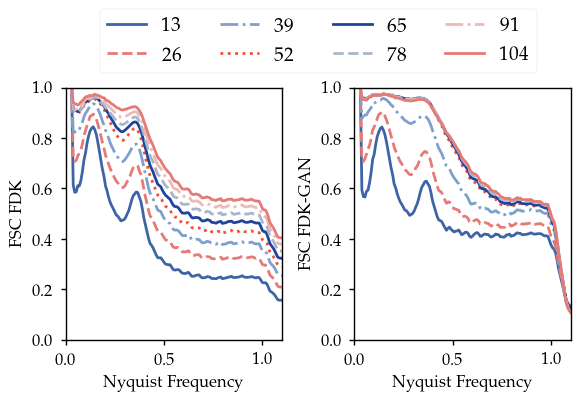

In [24]:
plot_fsc(outputs, outputs_enhanced, uniques, fq_keys, filter=4, ylabel1="FSC FDK", ylabel2="FSC FDK-GAN", save=True, folder="Hourglass4D", savefile="FSC_Hourglass4D_enhancement", ncols=4)

(26529,)


100%|██████████| 6291456/6291456 [00:04<00:00, 1422483.25it/s]


26529


100%|██████████| 26529/26529 [00:01<00:00, 14306.40it/s]


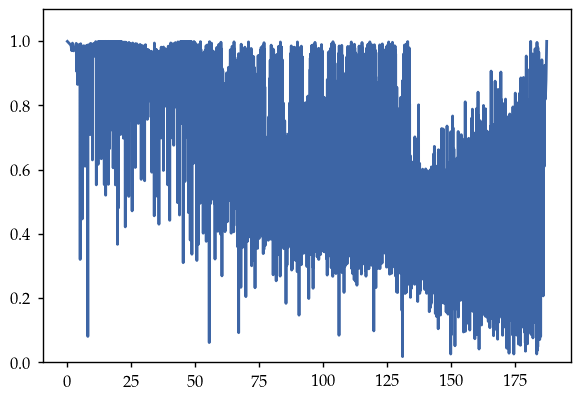

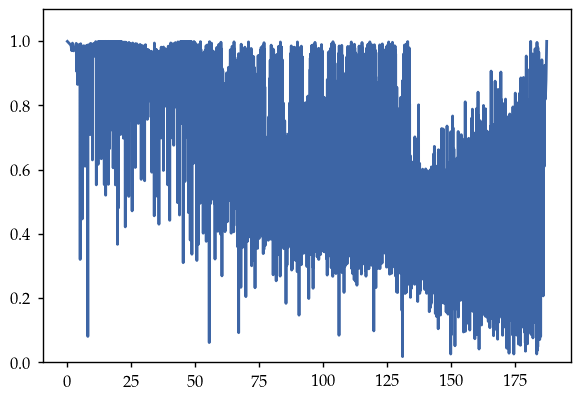

[0.5627919  0.44748786 0.5613955  0.7753498  0.5759626  0.42164364
 0.38712743 0.37881863 0.40369618 0.44903865]
[ 0.01545656 -0.00435149 -0.06927208  0.03174017 -0.00978474  0.00845101
  0.03243356  0.02997222  0.00043247 -0.03958285]
[0.96922606+0.j 0.97657967+0.j 0.97564167+0.j 0.99552435+0.j
 0.99845517+0.j 0.961733  +0.j 0.9924488 +0.j 0.30492252+0.j
 0.97629327+0.j 0.9265775 +0.j]
[3.29587325 3.30975092 3.31662479 3.32345619 3.33024571 3.34370152
 3.35036896 3.36358566 3.370136   3.37664838]
[10.86278049 10.95445115 11.         11.04536102 11.09053651 11.18033989
 11.22497216 11.3137085  11.35781669 11.40175425]


In [71]:


test = utils.FSC(gt_3D, ins_3D["104"], sizes=(evsizes[0], evsizes[1], evsizes[2]))

plt.plot(test[1], np.sqrt( (test[0]*np.conj(test[0])).real), label="13 Projections")
plt.ylim(0,1.1)
plt.show()

plt.plot(test[1], np.abs(test[0]), label="13 Projections")
plt.ylim(0,1.1)
plt.show()

print(test[0].real[10000:10010])
print(test[0].imag[10000:10010])

print((test[0]*np.conj(test[0]))[100:110])
print(np.sqrt(np.unique(test[1])[100:110]))
print(np.unique(test[1])[100:110])


In [104]:
def evaluate(x,y, normalise=False):

    # Normalises between 0 and 1
    if normalise:
        x = (x- np.min(x)) / (np.max(x)-np.min(x))
        y = (y- np.min(y)) / (np.max(y)-np.min(y))

    ssim = utils.calc_ssim(x, y)
    psnr = utils.calc_psnr(x, y)
    return ssim, psnr

ssims = {}
psnrs = {}
mssims = {}

x1, x2 = 160, 256
y1, y2 = 0, 256
z1, z2 = 0, 256

for k, v in crossections.items():
    if k == "gt":
        continue

    ss, ps = evaluate(crossections["gt"][x1:x2, y1:y2, z1:z2], v[x1:x2, y1:y2, z1:z2], normalise=True)
    ssims[k] = ss #utils.calc_ssim(crossections["gt"][x1:x2, y1:y2, z1:z2], v[x1:x2, y1:y2, z1:z2])
    psnrs[k] = ps #utils.calc_psnr(crossections["gt"][x1:x2, y1:y2, z1:z2], v[x1:x2, y1:y2, z1:z2])

    mssim_sum = 0
    for i in range(x2-x1):
        val, _ = utils.calc_mssim(crossections["gt"][x1 + i:x1+ 1 +i, y1:y2, z1:z2], v[x1 + i:x1+ 1 +i, y1:y2, z1:z2])
        mssim_sum += val
    mssims[k] = mssim_sum/(x2-x1)  #utils.calc_mssim(crossections["gt"][h, y1:y2, z1:z2], v[h, y1:y2, z1:z2] ) #mssim_sum / len(v) #



print(ssims)
print(psnrs)
print(mssims)

{'13': 0.5601214599406201, '26': 0.656904774811129, '39': 0.7931413686720632, '52': 0.8509225484476782, '65': 0.8632490446819554, '78': 0.8802282361129609, '91': 0.9160799967128046, '104': 0.9438070909838753, '13_enhanced': 0.7489658619063506, '26_enhanced': 0.9202464726654211, '39_enhanced': 0.9893629630572148, '52_enhanced': 0.9837522186838336, '65_enhanced': 0.9805516456264729, '78_enhanced': 0.9772375749220833, '91_enhanced': 0.9736348676645061, '104_enhanced': 0.9664508352708121}
{'13': 10.573793329625508, '26': 12.256142685482338, '39': 14.96561894965863, '52': 16.75667832195976, '65': 17.117134579422416, '78': 17.82077394922996, '91': 19.647140970370742, '104': 21.60953355960071, '13_enhanced': 13.682473390909806, '26_enhanced': 19.791095768206244, '39_enhanced': 27.82903141247996, '52_enhanced': 27.907857580222384, '65_enhanced': 27.42074725206326, '78_enhanced': 26.905523913944783, '91_enhanced': 26.431310467775027, '104_enhanced': 25.631312456179746}
{'13': 0.1631158284532527

In [86]:
def plot_attr_development(x, attrs, labels, xlabel="Projections", ylabel="SSIM", title="GAN Global Performance", folder="Hourglass4D", save=False, savefile="GAN_global_performance", ylim=(0,1), columns=1):

    def proj_to_factor(x):
        return 256*np.pi/2 / x
        

    def factor_to_proj(x):
        return 256*np.pi/2 / x

    fig, ax = plt.subplots(1,1, )

    for attr, label in zip(attrs, labels):
        ax.plot(x, attr, "D:", label=label)
    # ax.plot(x, attrs, "D:", label=labels)

    ax2 = ax.secondary_xaxis('top', functions=(factor_to_proj, proj_to_factor)) #ax1.twiny()

    ax2.set_xlabel("Nyquist Undersampling Factor")
    ax2.set_xticks([2**i for i in range(1,6)])
    ax2.set_xticklabels([2**i for i in range(1,6)])

    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_ylim(ylim)
    # ax.set_ylim([-20,20])
    ax.legend(ncol=columns)
    ax.set_title(title)

    if save:
        plt.savefig(f"../Results/{folder}/{savefile}.pdf", format="pdf")
    
    plt.show()

[33.71490212 40.08826057 24.73980076 15.61007761 13.58850052 11.02093012
  6.28273417  2.39919201]
[29.39985646 61.47899283 85.95309359 66.54767159 60.19472842 50.97842546
 34.53005965 18.61113238]


C:\Users\Bruker\OneDrive\Dokumenter\NTNU\4D_CT\Plotting\plots.py:618: RuntimeWarning: divide by zero encountered in divide
  return 256 * np.pi / 2 / x


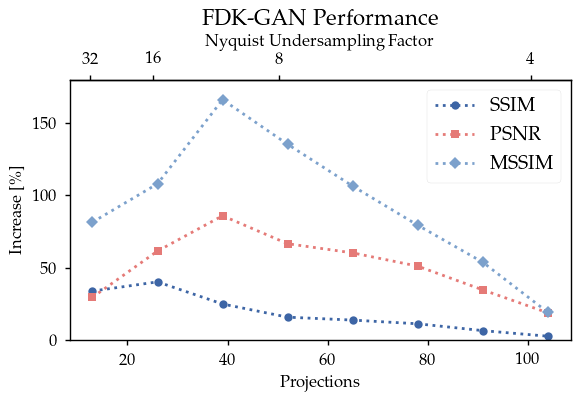

In [116]:
unenhanced = ssims["13"], ssims["26"], ssims["39"], ssims["52"], ssims["65"], ssims["78"], ssims["91"], ssims["104"]
enhanced = ssims["13_enhanced"], ssims["26_enhanced"], ssims["39_enhanced"], ssims["52_enhanced"], ssims["65_enhanced"], ssims["78_enhanced"], ssims["91_enhanced"], ssims["104_enhanced"]

increase = (np.array(enhanced) - np.array(unenhanced) )/ np.array(unenhanced)


unenhanced = psnrs["13"], psnrs["26"], psnrs["39"], psnrs["52"], psnrs["65"], psnrs["78"], psnrs["91"], psnrs["104"]
enhanced = psnrs["13_enhanced"], psnrs["26_enhanced"], psnrs["39_enhanced"], psnrs["52_enhanced"], psnrs["65_enhanced"], psnrs["78_enhanced"], psnrs["91_enhanced"], psnrs["104_enhanced"]

p_increase = (np.array(enhanced) - np.array(unenhanced) )/ np.array(unenhanced)

print(increase*100)
print(p_increase*100)

unenhanced = mssims["13"], mssims["26"], mssims["39"], mssims["52"], mssims["65"], mssims["78"], mssims["91"], mssims["104"]
enhanced = mssims["13_enhanced"], mssims["26_enhanced"], mssims["39_enhanced"], mssims["52_enhanced"], mssims["65_enhanced"], mssims["78_enhanced"], mssims["91_enhanced"], mssims["104_enhanced"]

m_increase = (np.array(enhanced) - np.array(unenhanced) )/ np.array(unenhanced)

plot_attr_development([13,26,39, 52, 65, 78, 91,104], [increase*100, p_increase*100, m_increase*100], ["SSIM", "PSNR", "MSSIM" ], xlabel="Projections", ylabel="Increase [\%]", title="FDK-GAN Performance", folder="Hourglass4D", save=True, ylim=(0,180), savefile="FDKGAN_performance_increase")


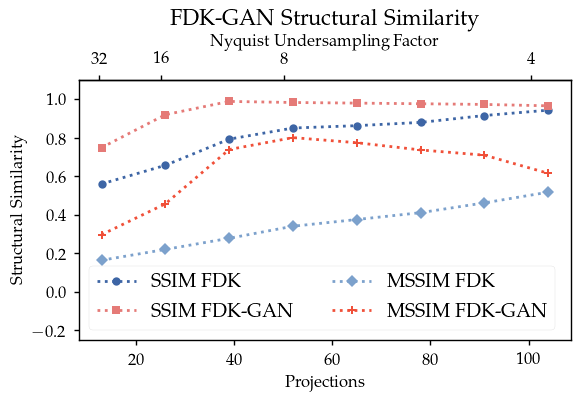

In [117]:
k_in = ["13", "26", "39", "52", "65", "78", "91", "104"]
k_out = ["13_enhanced", "26_enhanced", "39_enhanced", "52_enhanced", "65_enhanced", "78_enhanced", "91_enhanced", "104_enhanced"]

unenhanced_ssim = [ssims[k] for k in k_in]
enhanced_ssim = [ssims[k] for k in k_out]

unenhanced_mssim = [mssims[k] for k in k_in]
enhanced_mssim = [mssims[k] for k in k_out]

plot_attr_development(
    [13,26,39, 52, 65, 78, 91,104],
    [unenhanced_ssim, enhanced_ssim, unenhanced_mssim, enhanced_mssim],
    ["SSIM FDK", "SSIM FDK-GAN", "MSSIM FDK", "MSSIM FDK-GAN"],
    xlabel="Projections",
    ylabel="Structural Similarity",
    title="FDK-GAN Structural Similarity",
    folder="Hourglass4D",
    save=True,
    savefile="GAN_global_performance_ssim_mssim",
    ylim=(-0.25,1.1),
    columns=2
)
    

In [156]:
ssims = {}
psnrs = {}
mssims = {}

x1, x2 = 160, 256
y1, y2 = 0, 256
z1, z2 = 0, 256

for k, v in it_crossections.items():
    if k == "gt":
        continue

    ss, ps = evaluate(crossections["gt"][x1:x2, y1:y2, z1:z2], v[x1:x2, y1:y2, z1:z2], normalise=True)
    ssims[k] = ss #utils.calc_ssim(crossections["gt"][x1:x2, y1:y2, z1:z2], v[x1:x2, y1:y2, z1:z2])
    psnrs[k] = ps #utils.calc_psnr(crossections["gt"][x1:x2, y1:y2, z1:z2], v[x1:x2, y1:y2, z1:z2])

    mssim_sum = 0
    for i in range(x2-x1):
        val, _ = utils.calc_mssim(crossections["gt"][x1 + i:x1+ 1 +i, y1:y2, z1:z2], v[x1 + i:x1+ 1 +i, y1:y2, z1:z2])
        mssim_sum += val
    mssims[k] = mssim_sum/(x2-x1)  #utils.calc_mssim(crossections["gt"][h, y1:y2, z1:z2], v[h, y1:y2, z1:z2] ) #mssim_sum / len(v) #

print(ssims)
print(psnrs)
print(mssims)

{'26': 0.9411729846936275, '52': 0.956869628813758}
{'26': 22.22865622584235, '52': 23.441558893243005}
{'26': 0.359319762326777, '52': 0.38587913289666176}


In [157]:
def SIRT_table(attr,name, projections, cols=4, int_lenght=1):

    tab = []
    #Initializing tabular env
    cs = ""
    for i in range(cols):
        cs += "c "
    tab.append("\\begin{tabular}{%s}"%cs)

    #creating header
    tab.append("\\hline")
    tab.append("\\multicolumn{%i}{c}{\\textbf{%s}} \\\\"%(cols, name))

    header_titles = "\\textbf{Projections} & \\textbf{SSIM} &\\textbf{MSSIM} & \\textbf{PSNR}  \\\\" #%(cols-1)
    tab.append(header_titles)
    # header = ""
    # for i in range(len(exposures)):
    #     header += "& \\textbf{\\num{%s}%s} "%(exposures[i][:-1], exposures[i][-1])
    # header += "\\\\"
    # tab.append(header)
    tab.append("\\hline")

    for j, id in enumerate(projections):
        row = "\\textbf{%s} "%id
        for i, (k, v) in enumerate(attr.items()):
            if int_lenght == 1:
                row += "& \\num{%.3f}"%attr[k][id]
            elif int_lenght >=3:
                row += "& \\num{%.0f}"%attr[k][id]
            else:
                row += "& \\num{%.2f}"%attr[k][id]
        row += "\\\\"
        tab.append(row)

    #Finishing tabular env
    tab.append("\\hline")
    tab.append("\\end{tabular}")
    return tab

In [159]:
tab = SIRT_table({"ssim":ssims, "mssim":mssims, "psnr":psnrs},"SIRT", ["26", "52"], cols=4, int_lenght=2)
for t in tab:
    print(t)

\begin{tabular}{c c c c }
\hline
\multicolumn{4}{c}{\textbf{SIRT}} \\
\textbf{Projections} & \textbf{SSIM} &\textbf{MSSIM} & \textbf{PSNR}  \\
\hline
\textbf{26} & \num{0.94}& \num{0.36}& \num{22.23}\\
\textbf{52} & \num{0.96}& \num{0.39}& \num{23.44}\\
\hline
\end{tabular}


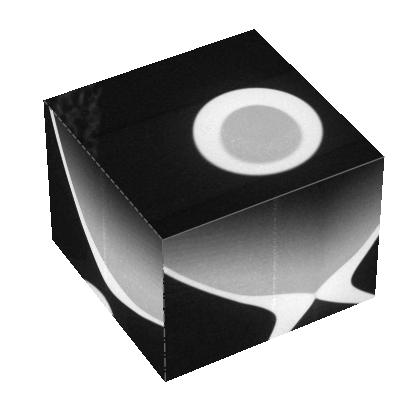

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Define dimensions
Nx, Ny, Nz = 256, 256, 256
X, Y, Z = np.meshgrid(np.arange(Nx), np.arange(Ny), -np.arange(Nz))

# Create fake data
data = crossections["gt"].transpose(2,1,0)

kw = {
    'vmin': data.min(),
    'vmax': data.max(),
    'levels': np.linspace(data.min(), data.max(), 100),
    'cmap': 'gray',
}

# Create a figure with 3D ax
fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(111, projection='3d')

# Plot contour surfaces
_ = ax.contourf(
    X[:, :, 0], Y[:, :, 0], data[:, :, 180],
    zdir='z', offset=0, **kw
)
_ = ax.contourf(
    X[0, :, :], data[128, :, :], Z[0, :, :],
    zdir='y', offset=0, **kw
)
C = ax.contourf(
    data[:, 128, :], Y[:, -1, :], Z[:, -1, :],
    zdir='x', offset=X.max(), **kw
)
# --


# Set limits of the plot from coord limits
xmin, xmax = X.min(), X.max()
ymin, ymax = Y.min(), Y.max()
zmin, zmax = Z.min(), Z.max()
ax.set(xlim=[xmin, xmax], ylim=[ymin, ymax], zlim=[zmin, zmax])

# Plot edges
edges_kw = dict(color='0.4', linewidth=1, zorder=1e3)
ax.plot([xmax, xmax], [ymin, ymax], 0, **edges_kw)
ax.plot([xmin, xmax], [ymin, ymin], 0, **edges_kw)
ax.plot([xmax, xmax], [ymin, ymin], [zmin, zmax], **edges_kw)

# Set labels and zticks
ax.set(
    xlabel='X [km]',
    ylabel='Y [km]',
    zlabel='Z [m]',
    # zticks=[0, -150, -300, -450],
)

# Set zoom and angle view
ax.view_init(40, -30, 0)
ax.set_axis_off()
# ax.set_box_aspect(None, zoom=0.9)

# Colorbar
# fig.colorbar(C, ax=ax, fraction=0.02, pad=0.1, label='Name [units]')

# Show Figure
plt.show()

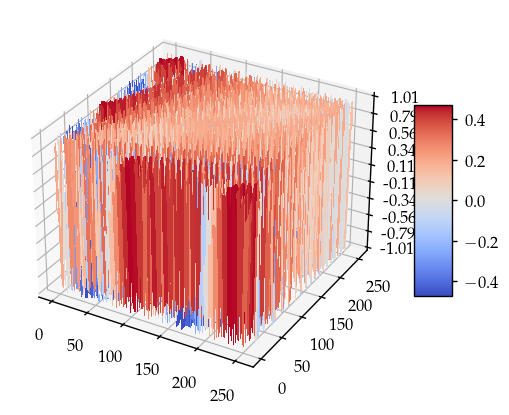

In [11]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.

X, Y = np.meshgrid(np.arange(Nx), np.arange(Ny))
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

KeyboardInterrupt: 

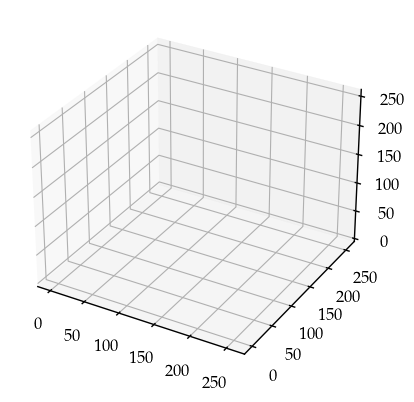

In [24]:
# prepare some coordinates
x, y, z = np.indices((256, 256, 256))

# draw cuboids in the top left and bottom right corners, and a link between
# them
cube1 = (x < 3) & (y < 3) & (z < 3)
cube2 = (x >= 5) & (y >= 5) & (z >= 5)
link = abs(x - y) + abs(y - z) + abs(z - x) <= 2



voxelarray = np.zeros((256,256,256))
colors = np.empty(voxelarray.shape, dtype=object)

cmap = plt.cm.gray
norm = plt.Normalize(vmin=crossections["52_enhanced"].min(), vmax=crossections["52_enhanced"].max())

for i in range(pixels.shape[0]):
    x, y, z = pixels[i]
    voxelarray[x,y,z] = True
    colors[x,y,z] = cmap(norm(intensities[x,y,z]))


# combine the objects into a single boolean array
# voxelarray = np.where()#(x in pixels[:,0]) & (y in pixels[:,1]) & (z in pixels[:,2]) #cube1 | cube2 | link


# set the colors of each object

# colors[link] = 'red'
# colors[cube1] = 'blue'
# colors[cube2] = 'green'

# and plot everything
ax = plt.figure().add_subplot(projection='3d')
ax.voxels(voxelarray, facecolors=colors, edgecolor='k')
plt.show()


In [7]:
X, Y, Z = np.indices((256, 256, 256))
intensities = crossections["52_enhanced"].transpose(2,1,0)
pixels = np.argwhere(intensities > 0.60)
X = X[pixels[:,0], pixels[:,1], pixels[:,2]]
Y = Y[pixels[:,0], pixels[:,1], pixels[:,2]]
Z = 256- Z[pixels[:,0], pixels[:,1], pixels[:,2]]
V = intensities[pixels[:,0], pixels[:,1], pixels[:,2]]
X = X.flatten()
Y = Y.flatten()
Z = Z.flatten()
V = V.flatten()

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# voxel_size = (1,1,1)
# ax.scatter(X, Y, Z, c=V, cmap='gray', norm=mpl.colors.Normalize(vmin=0, vmax=np.max(V)), s=1, alpha=V, marker=",")
# # Set the aspect ratio of the plot to match the voxel size
# ax.set_box_aspect(voxel_size)
# # Adjust the viewing angle for better visualization (optional)
# ax.view_init(elev=30, azim=-60)  # Adjust as desired
# # ax.set_axis_off()
# plt.show()

(264, 264, 448)
0.0 1.0
0.039030463 0.5014762
(333957,)
(333957, 3)
(664802, 3)
(664802, 4)
(664802, 4)


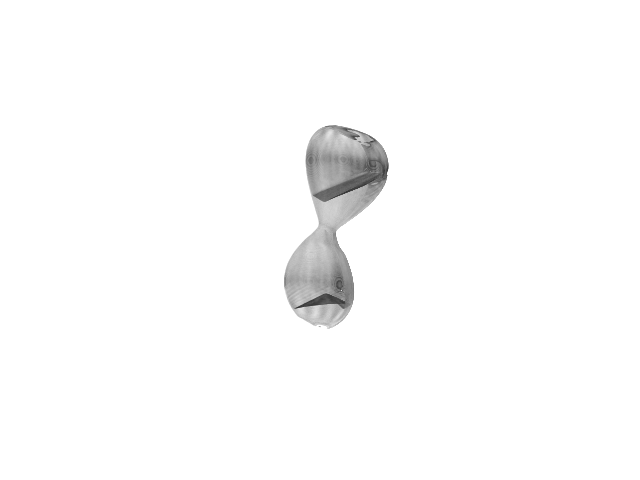

In [62]:
# ct_data = np.load('ct_reconstruction.npy')
from skimage import measure
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

# Create a figure and axes for the 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
binned_path = r"C:\Users\Bruker\Documents\MAX4DCT\hourglassV3_13_55_2bin_Rec_25_4_fdk_enhanced_442256256_0_448_0_264_0_264.npy"

intensities = np.load(binned_path).transpose(2,1,0)

print(intensities.shape)

# Option 1: Using Matplotlib's imshow3D for volume rendering
# ax.imshow3D(intensities, cmap='gray')

# Option 2: Using scikit-image's marching_cubes for surface extraction and visualization
verts, faces, _, vals = measure.marching_cubes(intensities[:156,:,:], level=0.50)

print(np.min(intensities), np.max(intensities))
print(np.min(vals), np.max(vals))

print(vals.shape)
print(verts.shape)
print(faces.shape)

cmap = plt.cm.gray
norm = plt.Normalize(vmin=vals.min()*0, vmax=vals.max())
cs = cmap(norm(vals))
retur = ax.plot_trisurf(verts[:, 0], verts[:, 1], 448-verts[:, 2], triangles=faces,)# cmap="gray", alpha=0.5)

fcs = retur._facecolors
print(fcs.shape)

colors = np.mean(cs[faces], axis=1)

print(colors.shape)
# retur.set_array(cs)

for i in range(colors.shape[0]):
    fcs[i] = colors[i]
    # fcs[i,3] = 0.5
# Set the aspect ratio of the plot
ax.set_box_aspect([1, 1, 1])
ax.set_xlim(0, 448)
ax.set_ylim(0, 448)
ax.set_zlim(0, 448)

# Adjust the viewing angle for better visualization (optional)
ax.view_init(elev=10, azim=45)  # Adjust as desired
ax.set_axis_off()

# Display the plot
plt.savefig("3d_final3.png", format="png", dpi=300)
plt.show()

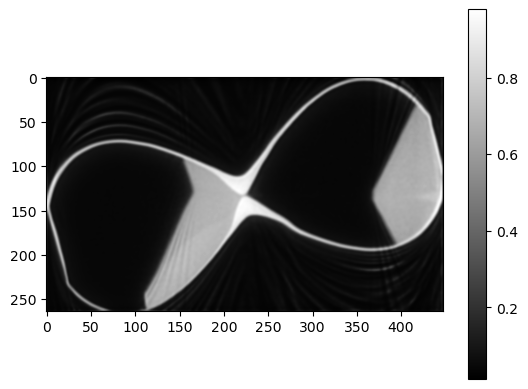

In [45]:
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
binned_path = r"C:\Users\Bruker\Documents\MAX4DCT\hourglassV3_13_55_2bin_Rec_25_4_fdk_enhanced_442256256_0_448_0_264_0_264.npy"
%matplotlib inline

intensities = np.load(binned_path).transpose(2,1,0)

plt.imshow(np.squeeze(intensities[156,:,:]), cmap="gray", aspect="equal")
plt.colorbar()
plt.show()